In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import torch
import torchvision
from utils import plot_image
import torch.nn.functional as F

### Class labels
airplane: 0 \
automobile: 1\
bird: 2\
cat: 3\
deer: 4\
dog: 5\
frog: 6\
horse: 7\
ship: 8\
truck: 9

In [2]:
ind_to_classname = {0:'airplane',
                    1:'automobile',
                    2:'bird',
                    3:'cat',
                    4:'deer',
                    5:'dog',
                    6:'frog',
                    7:'horse',
                    8:'ship',
                    9:'truck',
                   }

In [3]:
adv = np.load("adversarials/fgsm.npy")

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

real_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)

real_loader = torch.utils.data.DataLoader(
    real_dataset, batch_size=100, shuffle=False, num_workers=4)

Files already downloaded and verified


In [12]:
class Adv_dataset(torch.utils.data.Dataset):
    def __init__(self, X_adv):
        self.X = X_adv
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], 1
    
adv_dataset = Adv_dataset(adv)
adv_dataloader = torch.utils.data.DataLoader(adv_dataset, batch_size=100,
                                            num_workers=0)

In [13]:
from vgg import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'

VGG_16 = [64, 64, 'pooling', 128, 128, 'pooling', 256, 256,
          256, 'pooling', 512, 512, 512, 'pooling', 512, 512, 512, 'pooling']

model = VGG(VGG_16)
model = model.to(device)
model.eval()

model.load_state_dict(torch.load('models_weights/vggModel'))

<All keys matched successfully>

network prediction: deer, real class: deer


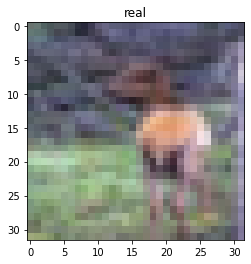

In [14]:
random_index = np.random.randint(0, min(len(adv), len(real_dataset)))
random_real = torch.argmax(model(real_dataset[random_index][0].unsqueeze(0).to(device))).item()
print(f"network prediction: {ind_to_classname[random_real]}, real class: {ind_to_classname[real_dataset.targets[random_index]]}")
plot_image(real_dataset[random_index], title="real")

network prediction on adversarial: dog


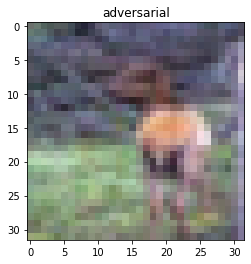

In [15]:
random_adv = torch.argmax(model(torch.from_numpy(adv[random_index]).unsqueeze(0).to(device))).item()
print(f"network prediction on adversarial: {ind_to_classname[random_adv]}")
plot_image(adv[random_index], title='adversarial')

In [22]:
from sklearn.utils import shuffle

class ml_adv_detector():
    
    def __init__(self, network, detector, params=None):
        '''
        network - neural network that is used to predict softmax
        detector - ML model with sklearn API
        params: expected to be a dictionary of detector parameters
        '''
        self.network = network
        self.detector = detector
        if params != None:
            self.detector.set_params(*params)
        
    def fit(self, X_real, X_adversarial):
        '''   
        X_real - torch dataloader
        X_adversarial - torch dataloader
        '''
        assert type(X_real) == torch.utils.data.dataloader.DataLoader
        assert type(X_adversarial) == torch.utils.data.dataloader.DataLoader
        
        X_softmax = []
        
        for x, y in X_real:
            x = x.to(device)
            outputs = F.softmax(self.network(x)).detach().cpu().numpy()
            X_softmax.extend(outputs)
        

        for x, y in X_adversarial:
            x = x.to(device)
            outputs = F.softmax(self.network(x)).detach().cpu().numpy()
            X_softmax.extend(outputs)  
       
        X_softmax = np.array(X_softmax)
        
        y = np.concatenate((np.array([0] * len(X_real.dataset)),
                            np.array([1] * len(X_adversarial.dataset))))
        
        X_softmax, y = shuffle(X_softmax, y)
        
        self.detector.fit(X_softmax, y)                    
            
    def predict(self, X):
        '''
        return result of detection (1 - adversarial, 0 - natural)
        X - torch dataloader
        '''
        X_softmax = []
        
        for x, y in X:
            x = x.to(device)
            outputs = F.softmax(self.network(x)).detach().cpu().numpy()
            X_softmax.extend(outputs)
        
        
        X_softmax = np.array(X_softmax)
        return np.round(self.detector.predict(X_softmax))

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [24]:
logreg_det = ml_adv_detector(model, LogisticRegression())

In [25]:
logreg_det.fit(real_loader, adv_dataloader)

<ipython-input-22-a659bc937996>:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = F.softmax(self.network(x)).detach().cpu().numpy()
<ipython-input-22-a659bc937996>:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = F.softmax(self.network(x)).detach().cpu().numpy()


In [26]:
real_pred = logreg_det.predict(real_loader)

<ipython-input-22-a659bc937996>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = F.softmax(self.network(x)).detach().cpu().numpy()


In [27]:
adv_pred = logreg_det.predict(adv_dataloader)

<ipython-input-22-a659bc937996>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = F.softmax(self.network(x)).detach().cpu().numpy()


In [29]:
real_pred.sum()

4996

In [31]:
adv_pred.sum()

5890

In [33]:
randforest_det = ml_adv_detector(model, RandomForestClassifier())
randforest_det.fit(real_loader, adv_dataloader)

<ipython-input-22-a659bc937996>:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = F.softmax(self.network(x)).detach().cpu().numpy()
<ipython-input-22-a659bc937996>:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = F.softmax(self.network(x)).detach().cpu().numpy()


In [35]:
print(randforest_det.predict(real_loader).sum())
print(randforest_det.predict(adv_dataloader).sum())

<ipython-input-22-a659bc937996>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = F.softmax(self.network(x)).detach().cpu().numpy()


246


<ipython-input-22-a659bc937996>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = F.softmax(self.network(x)).detach().cpu().numpy()


9488
